In [55]:
!pip install biopython
!pip install chembl-webresource-client
!pip install rdkit

In [24]:
# Gerekli kütüphaneler: biopython, chembl_webresource_client, rdkit
from Bio import Entrez, SeqIO
import time
from chembl_webresource_client.new_client import new_client

# **NCBI üzerinden Lösemi ile ilgili olan ABL1 hedef proteinini çekiyoruz**

In [56]:
Entrez.email = "240542017@firat.edu.tr"
handle = Entrez.efetch(db="protein", id="NP_005148", rettype="fasta", retmode="text")
target_sequence = handle.read()
print("Hedef Protein İndirildi:", target_sequence[:50])

Hedef Protein İndirildi: >NP_005148.2 tyrosine-protein kinase ABL1 isoform 


In [57]:
with open("abl1_hedef_protein.fasta", "w") as f:
    f.write(target_sequence)

print("Başarılı! Hedef protein 'abl1_hedef_protein.fasta' olarak kaydedildi.")

Başarılı! Hedef protein 'abl1_hedef_protein.fasta' olarak kaydedildi.


<h1>Deleting duplicates for fasta file<h1/>

In [27]:
start = time.time()
seen = []
records = []
for record in SeqIO.parse("abl1_hedef_protein.fasta", "fasta"):
    if(str(record.seq) not in seen):
        seen.append(str(record.seq))
        records.append(record)
#Fasta dosyasını yeniden yazıyoruz.
SeqIO.write(records, "abl1_hedef_protein_tekrarsız.fasta", "fasta")
end = time.time()
print(f"Çalışma Süresi {(end- start)} saniye \n Yeni fasta dosyası 'abl1_hedef_protein_tekrarsız.fasta' adı ile kaydedildi")

Çalışma Süresi 0.0011906623840332031 saniye 
 Yeni fasta dosyası 'abl1_hedef_protein_tekrarsız.fasta' adı ile kaydedildi


In [47]:
# 2. ChEMBL'den Bu Hedefe Uygun İlaçları Bul
target = new_client.target
target_query = target.filter(target_synonym__icontains='ABL1').filter(target_organism__icontains='Homo sapiens')
target_id = target_query[0]['target_chembl_id']

activity = new_client.activity
res = activity.filter(target_chembl_id=target_id).filter(standard_type="IC50")

# İlaçların SMILES kodlarını topla
smiles_list = [x['canonical_smiles'] for x in res if x['canonical_smiles']]
print(f"{len(smiles_list)} adet potansiyel molekül bulundu.")

5287 adet potansiyel molekül bulundu.


In [48]:
from rdkit import Chem
import pandas as pd

# 1. Listeyi DataFrame'e (Tabloya) çevir
df = pd.DataFrame(smiles_list, columns=['SMILES'])

# 2. CSV dosyası olarak kaydet
df.to_csv('abl1_ilac_verisi.csv', index=False)

print(f"Başarılı! {len(df)} adet molekül 'abl1_ilac_verisi.csv' dosyasına kaydedildi.")

Başarılı! 5287 adet molekül 'abl1_ilac_verisi.csv' dosyasına kaydedildi.


In [50]:
def canonicalize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        else:
            return None # Geçersiz SMILES ise boş dön
    except:
        return None

# 2. İşlemi Uygula
print(f"Başlangıçtaki veri sayısı: {len(df)}")

# 'Canonical_SMILES' adında yeni bir sütun oluşturuyoruz
df['Canonical_SMILES'] = df['SMILES'].apply(canonicalize_smiles)

# 3. Geçersiz (None) olanları at (Bazen veritabanında hatalı kayıtlar olabilir)
df = df.dropna(subset=['Canonical_SMILES'])

# 4. ŞİMDİ kopyaları sil (Canonical sütununa göre)
df_clean = df.drop_duplicates(subset=['Canonical_SMILES'])

print(f"Temizlendikten sonraki veri sayısı: {len(df_clean)}")

# Temiz veriyi kullanalım
df_clean.to_csv('abl1_ilac_verisi_clean.csv', index=False)

Başlangıçtaki veri sayısı: 5287
Temizlendikten sonraki veri sayısı: 2851


In [51]:
df_clean

,SMILES,Canonical_SMILES
0,COc1ccc(-c2[nH]nc3c2C(=O)c2ccccc2-3)cc1,COc1ccc(-c2[nH]nc3c2C(=O)c2ccccc2-3)cc1
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
3,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...
5,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...
7,CC[C@H](NC(=O)[C@H](Cc1ccc(OP(=O)(O)O)cc1)NC(C...,CC[C@H](NC(=O)[C@H](Cc1ccc(OP(=O)(O)O)cc1)NC(C...
...,...,...
5282,CCC(NC(=O)c1ccc(C2CC2)c(-c2ccc3nc(Nc4cnn(C5CC5...,CCC(NC(=O)c1ccc(C2CC2)c(-c2ccc3nc(Nc4cnn(C5CC5...
5283,CC(NC(=O)c1ccc(C2CC2)c(-c2ccc3nc(Nc4cnn(C5CC5)...,CC(NC(=O)c1ccc(C2CC2)c(-c2ccc3nc(Nc4cnn(C5CC5)...
5284,CC(NC(=O)c1cccc(C(F)(F)F)c1)c1ccc(C2CC2)c(-c2c...,CC(NC(=O)c1cccc(C(F)(F)F)c1)c1ccc(C2CC2)c(-c2c...
5285,CCc1ccc(C(C)NC(=O)c2cccc(C(F)(F)F)c2)cc1-c1ccc...,CCc1ccc(C(C)NC(=O)c2cccc(C(F)(F)F)c2)cc1-c1ccc...


In [52]:
# Modelin ürettiği çıktıyı analiz etme ve eleme kısmı (Organ yetmezliği kısıtı)
from rdkit import Chem
from rdkit.Chem import Descriptors, QED

def check_drug_quality(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return False

    # 1. QED (Quantitative Estimation of Drug-likeness)
    # Bu skor ilacın genel olarak vücutta emilip emilemeyeceğini tahmin eder.
    qed_score = QED.qed(mol)

    # 2. Moleküler Ağırlık (Çok ağırsa böbreklerden atılamaz)
    mw = Descriptors.MolWt(mol)

    # Filtre: İlaç benzeri olsun VE çok ağır olmasın (Basit bir toksisite önlemi)
    if qed_score > 0.5 and mw < 500:
        return True, f"Molekül uygun. QED: {qed_score:.2f}, MW: {mw:.1f}"
    else:
        return False, "Uygunsuz."

# Örnek Kullanım
generated_molecule = "CCC1(c2ccc(N)cc2)CCC(=O)NC1=O" # (Imatinib benzeri bir yapı)
is_good, reason = check_drug_quality(generated_molecule)
print(reason)

Molekül uygun. QED: 0.60, MW: 232.3


We drawind molecules by using <span style="background-color: #2a2a2a; padding: 2px 5px; border-radius: 3px;">**Draw**</span>class of  <span style="background-color: #2a2a2a; padding: 2px 5px; border-radius: 3px;">rdkit </span>library.

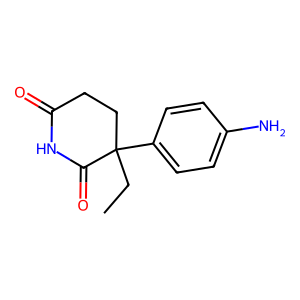

In [53]:
from  rdkit  import  Chem
from  rdkit.Chem  import  Draw

mol  =  Chem.MolFromSmiles("CCC1(c2ccc(N)cc2)CCC(=O)NC1=O")
Draw.MolToImage(mol)

In [54]:
import re

def tokenize_smiles(smiles):
    pattern = r"(\[[^\[\]]{1,6}\])"
    tokens = re.split(pattern, smiles)
    result = []
    for token in tokens:
        if token.startswith('['):
            result.append(token)
        else:
            result.extend(list(token))
    return result

# Example usage
print(tokenize_smiles('CC(=O)OC1=CC=CC=C1C(=O)O'))

['C', 'C', '(', '=', 'O', ')', 'O', 'C', '1', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '1', 'C', '(', '=', 'O', ')', 'O']
